In [1]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mahmo\AppData\Roaming\nltk_data...


True

In [3]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import time
import pandas as pd

# Initialize Chrome driver
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

# Open the CryptoPanic website
driver.get("https://cryptopanic.com")

# Allow time for the page to load (adjust as needed)
time.sleep(5)


In [7]:
# Find all news rows
news_rows = driver.find_elements(By.CSS_SELECTOR, "div.news-row.news-row-link")

# Prepare a list to store scraped records
records = []

for row in news_rows:
    # 1) Extract the date
    try:
        date_elem = row.find_element(By.CSS_SELECTOR, "a.news-cell.nc-date")
        date_text = date_elem.text.strip()
    except:
        date_text = None  # or ""

    # 2) Extract the title
    try:
        title_elem = row.find_element(By.CSS_SELECTOR, "a.news-cell.nc-title")
        title_text = title_elem.text.strip()
    except:
        title_text = None  # or ""

    # 3) Extract the news link from the title element (href)
    try:
        link = title_elem.get_attribute("href")
    except:
        link = None

    # 4) (Optional) Extract currency info
    try:
        currency_elem = row.find_element(By.CSS_SELECTOR, "div.news-cell.nc-currency")
        currency_text = currency_elem.text.strip()
    except:
        currency_text = None

    # Store the extracted info in a dictionary
    record = {
        "date": date_text,
        "title": title_text,
        "link": link,
        "currency_info": currency_text
    }
    records.append(record)

# Convert the list of records to a DataFrame
df = pd.DataFrame(records)
df.head()


,date,title,link,currency_info
0,24min,Le gouvernement salvadorien veut poursuivre so...,https://cryptopanic.com/news/20641557/Le-gouve...,BTC
1,27min,Binance Partners with xMoney to Expand Crypto ...,https://cryptopanic.com/news/20641544/Binance-...,None
2,30min,Solana Stablecoin TVL Doubles on TRUMP Frenzy:...,https://cryptopanic.com/news/20641546/Solana-S...,SOL TRUMP TRUMP …
3,36min,Crypto & Bourse : ce qu’il ne faut pas manquer...,https://cryptopanic.com/news/20641525/Crypto-B...,None
4,36min,Trader Nets Nearly $16 Million on Ethereum Sho...,https://cryptopanic.com/news/20641501/Trader-N...,ETH


In [8]:
driver.quit()


In [9]:
# Compute the number of words in the title
df['title_word_count'] = df['title'].apply(lambda x: len(x.split()))


In [10]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Compute the compound sentiment score for each title
df['sentiment'] = df['title'].apply(lambda text: sia.polarity_scores(text)['compound'])

# Inspect the updated DataFrame
print(df[['title', 'title_word_count', 'sentiment']].head())


                                               title  title_word_count  \
0  Le gouvernement salvadorien veut poursuivre so...                11   
1  Binance Partners with xMoney to Expand Crypto ...                 9   
2  Solana Stablecoin TVL Doubles on TRUMP Frenzy:...                 9   
3  Crypto & Bourse : ce qu’il ne faut pas manquer...                19   
4  Trader Nets Nearly $16 Million on Ethereum Sho...                10   

   sentiment  
0     0.0000  
1     0.3182  
2    -0.3182  
3     0.0000  
4     0.0000  


In [11]:
from sklearn.preprocessing import StandardScaler

# Select features
features = ['title_word_count', 'sentiment']
X = df[features].dropna()

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Run PCA to reduce to 2 components for visualization
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
df_pca = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

# Display explained variance ratios
print("Explained Variance Ratio:", pca.explained_variance_ratio_)


Explained Variance Ratio: [0.59486488 0.40513512]


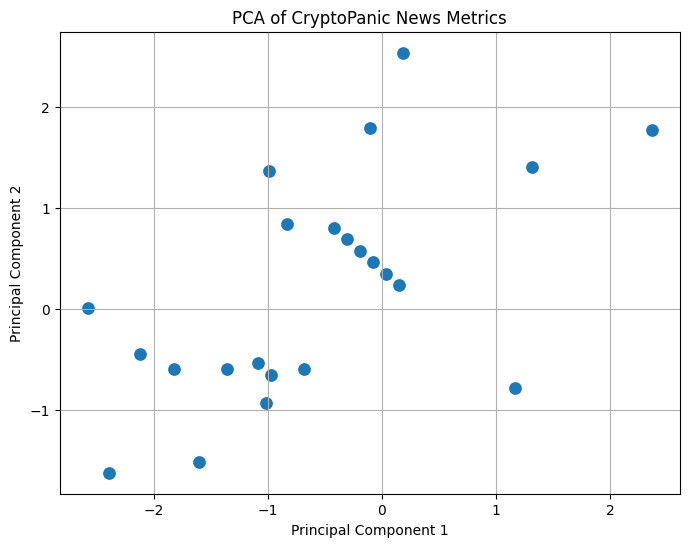

In [13]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=df_pca, s=100)
plt.title("PCA of CryptoPanic News Metrics")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()
